# Hospital Reviews Text Analysis

 **Objectives:**
  1. Identify broad areas of concern using LDA topic modeling
  2. Analyze customer sentiment using VADER
  3. Compare Logistic Regression to VADER

# Part 1: Setup and Data Inspection

In [31]:
#Imports
%pip install vaderSentiment
%pip install wordcloud

import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    confusion_matrix, accuracy_score, 
    precision_score, recall_score, classification_report
)
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud



# NLTK for text preprocessing
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Add the default NLTK data path to the list of paths
nltk.data.path.append('/root/nltk_data')

# Ensure NLTK data is downloaded
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lab_services_student\AppData\Roaming\nltk_dat
[nltk_data]     a...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\lab_services_student\AppData\Roaming\nltk_dat
[nltk_data]     a...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\lab_services_student\AppData\Roaming\nltk_dat
[nltk_data]     a...
[nltk_data]   Package wordnet is already up-to-date!


True

1. Load and Inspect Data

In [32]:
# Load Dataset
data_path = 'hospital.csv'
df = pd.read_csv(data_path)

In [33]:
# Display a sample
print("# Dataset Sample #")
display(df.head(10))

print("\n# Dataset Structure #")
print(f"• Rows: {df.shape[0]:,}")
print(f"• Columns: {df.shape[1]}")
print(f"• Duplicate rows: {df.duplicated().sum():,}")


df = df.drop_duplicates()
print(f"• Rows after removing duplicates: {df.shape[0]:,}")

df = df.drop(columns='Unnamed: 3') 
print("# Dataset Sample after removing unamed column #")
display(df.head(10))

null_counts = df.isnull().sum()
print(null_counts.to_markdown())

print("\n# Data Types #")
print(df.dtypes.to_markdown())

if 'sentiment' in df.columns:
    print("\n### Sentiment Distribution ###")
    print(df['sentiment'].value_counts().to_markdown())

if 'rating' in df.columns:
    print("\n### Rating Distribution ###")
    print(df['rating'].value_counts().sort_index().to_markdown())

# Dataset Sample #


,Feedback,Sentiment Label,Ratings,Unnamed: 3
0,Good and clean hospital. There is great team o...,1,5,NaN
1,Had a really bad experience during discharge. ...,1,5,NaN
2,I have visited to take my second dose and Proc...,1,4,NaN
3,That person was slightly clueless and offered...,1,3,NaN
4,There is great team of doctors and good OT fac...,0,1,NaN
5,My primary concern arose from the insistence o...,0,2,NaN
6,Good and clean hospital. The medical faciliti...,1,5,NaN
7,Recently underwent a surgery for my left shoul...,1,3,NaN
8,"Over all experience was good, starting from re...",1,5,NaN
9,"However,the services of front office (where we...",1,5,NaN



# Dataset Structure #
• Rows: 996
• Columns: 4
• Duplicate rows: 19
• Rows after removing duplicates: 977
# Dataset Sample after removing unamed column #


,Feedback,Sentiment Label,Ratings
0,Good and clean hospital. There is great team o...,1,5
1,Had a really bad experience during discharge. ...,1,5
2,I have visited to take my second dose and Proc...,1,4
3,That person was slightly clueless and offered...,1,3
4,There is great team of doctors and good OT fac...,0,1
5,My primary concern arose from the insistence o...,0,2
6,Good and clean hospital. The medical faciliti...,1,5
7,Recently underwent a surgery for my left shoul...,1,3
8,"Over all experience was good, starting from re...",1,5
9,"However,the services of front office (where we...",1,5


|                 |   0 |
|:----------------|----:|
| Feedback        |   0 |
| Sentiment Label |   0 |
| Ratings         |   0 |

# Data Types #
|                 | 0      |
|:----------------|:-------|
| Feedback        | object |
| Sentiment Label | int64  |
| Ratings         | int64  |


# Interpritation:

The dataset contains 996 patient feedback entries with complete data in the core columns (Feedback, Sentiment Label, and Ratings), though an entirely null (Unnamed: 3) column was  removed. While there are no missing values in key fields, 19 duplicate entries were removed as well The dataset shows promise for topic modeling and sentiment analysis once cleaned and validated.

2. Text Preprocessing

In [34]:
def preprocess_text(text):
    # make all text lowercase
    text = text.lower()
    # Remove numbers and punctuation and split into tokens
    tokens = re.findall(r'\b[a-z]+\b', text)
    # Remove stopwords
    stops = set(stopwords.words('english'))
    tokens = [t for t in tokens if t not in stops and len(t) > 2]
    # Lemmatize
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(t) for t in tokens]
    return ' '.join(tokens)

# Apply preprocessing to feedback column
df['clean_feedback'] = df['Feedback'].astype(str).apply(preprocess_text)

# Inspect cleaned text
display(df[['Feedback', 'clean_feedback']].head())

,Feedback,clean_feedback
0,Good and clean hospital. There is great team o...,good clean hospital great team doctor good fac...
1,Had a really bad experience during discharge. ...,really bad experience discharge need sensitive...
2,I have visited to take my second dose and Proc...,visited take second dose process really smooth...
3,That person was slightly clueless and offered...,person slightly clueless offered one package g...
4,There is great team of doctors and good OT fac...,great team doctor good facility


3. Extract Topics

In [35]:
# TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_df=0.95, min_df=2)
dtm = vectorizer.fit_transform(df['clean_feedback'])

# Fit LDA
n_topics = 5  # adjust number of topics
lda_model = LatentDirichletAllocation(n_components=n_topics, random_state=42)
lda_model.fit(dtm)

# Display topics
def display_topics(model, feature_names, num_top_words):
    for idx, topic in enumerate(model.components_):
        top_features = [feature_names[i] for i in topic.argsort()[:-num_top_words - 1:-1]]
        print(f'Topic {idx+1}: ' + ', '.join(top_features))

feature_names = vectorizer.get_feature_names_out()
display_topics(lda_model, feature_names, 10)


Topic 1: hospital, experience, treatment, happy, well, good, doctor, service, got, surgery
Topic 2: treatment, care, patient, good, really, food, excellent, staff, doctor, nurse
Topic 3: worst, doctor, ever, one, hospital, experience, emergency, patient, even, time
Topic 4: hospital, staff, patient, good, experience, care, best, one, money, manipal
Topic 5: good, hospital, staff, service, doctor, excellent, experience, patient, well, nursing


Review counts per topic:
1    186
2    152
3    147
4    182
5    310
Name: count, dtype: int64


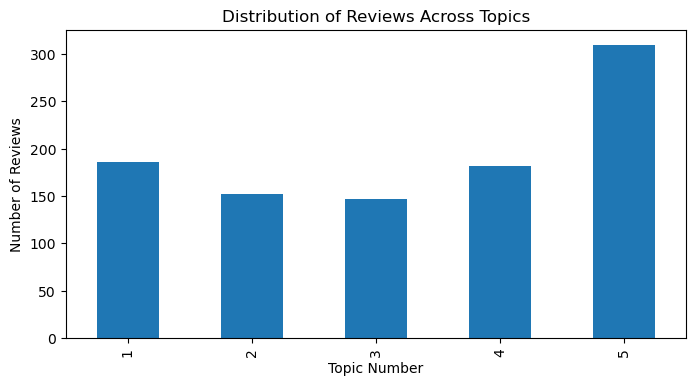

In [36]:
# Check distribution of topics
# Assign each document to its most probable topic
topic_assignments = lda_model.transform(dtm).argmax(axis=1) + 1
topic_counts = pd.Series(topic_assignments).value_counts().sort_index()
print('Review counts per topic:')
print(topic_counts)

# Visualize topic distribution
plt.figure(figsize=(8,4))
topic_counts.plot(kind='bar')
plt.xlabel('Topic Number')
plt.ylabel('Number of Reviews')
plt.title('Distribution of Reviews Across Topics')
plt.show()


# Part 2: Sentiment Analysis using LogisticRegression

1. Prepare Sentiment Lables

In [ ]:
# Code inspired by:
# "Hands-On Machine Learning: Logistic Regression with Python and Scikit-Learn by Ryan & Matt Data Science"
# YouTube link: https://youtu.be/aL21Y-u0SRs?si=_AOJbJE3nXgkGYKp
# Accessed on: June 24 2025

# We already have df['Sentiment Label'] with values 0 (negative) and 1 (positive)
y = df['Sentiment Label']


In [38]:

# Split into train/test (stratify to keep class balance)
X_train, X_test, y_train, y_test = train_test_split(
    df['clean_feedback'], 
    y, 
    test_size=0.2, 
    random_state=42,
    stratify=y
)

# Vectorize text with TF-IDF
tfidf = TfidfVectorizer(
    lowercase=True,
    stop_words='english',
    min_df=5
)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf  = tfidf.transform(X_test)

# Train Model
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train_tfidf, y_train)

LogisticRegression(max_iter=1000)

3 Evaluate and Visualise results

In [39]:
# a) Make predictions
y_pred = clf.predict(X_test_tfidf)

# b) Compute metrics
acc  = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec  = recall_score(y_test, y_pred)

print(f"Accuracy : {acc:.3f}")
print(f"Precision: {prec:.3f}")
print(f"Recall   : {rec:.3f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['negative','positive']))


Accuracy : 0.821
Precision: 0.818
Recall   : 0.972

Classification Report:
              precision    recall  f1-score   support

    negative       0.85      0.42      0.56        53
    positive       0.82      0.97      0.89       143

    accuracy                           0.82       196
   macro avg       0.83      0.69      0.72       196
weighted avg       0.83      0.82      0.80       196



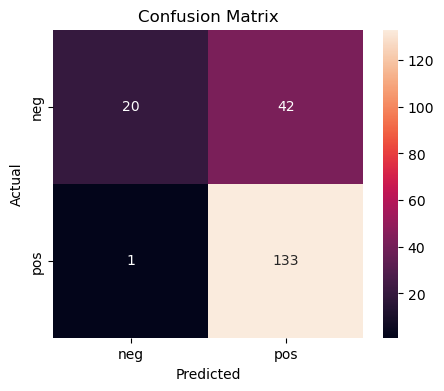

In [ ]:
# Code inspired by:
# "Hands-On Machine Learning: Create a confusion matrix with Python by Jacob Murel, Ph.D."
#  Link: https://developer.ibm.com/tutorials/awb-confusion-matrix-python/
# Accessed on: June 24 2025


# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', 
            xticklabels=['neg','pos'], 
            yticklabels=['neg','pos'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

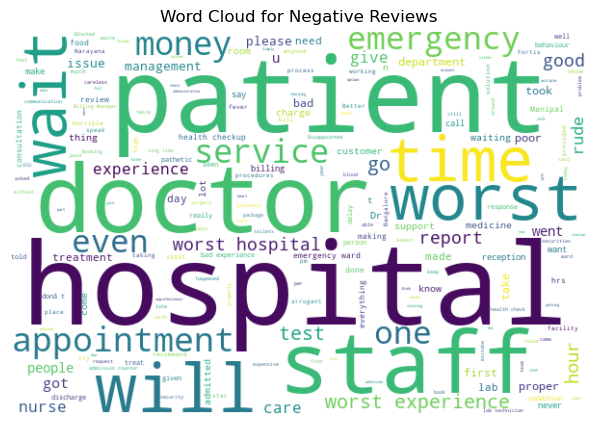

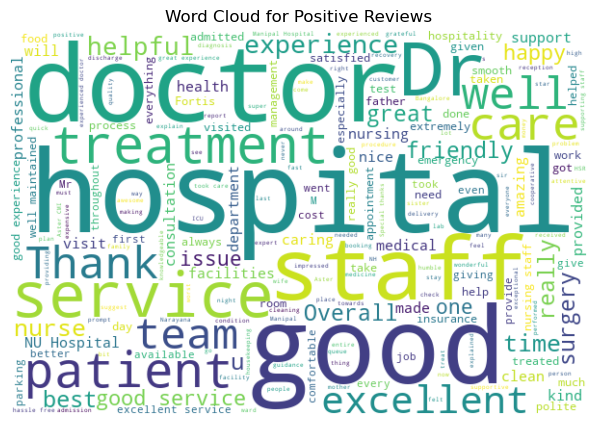

In [ ]:


# Word clouds per sentiment category
for label, name in zip([0, 1], ['negative', 'positive']):
    text = " ".join(df.loc[df['Sentiment Label'] == label, 'Feedback'])
    wc = WordCloud(width=600, height=400, background_color='white').generate(text)
    plt.figure(figsize=(8,5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Word Cloud for {name.capitalize()} Reviews")
    plt.show()

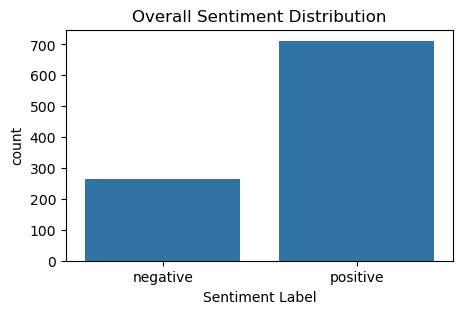

In [42]:
# Overall Sentiment Distribution
plt.figure(figsize=(5,3))
sns.countplot(x='Sentiment Label', data=df)
plt.xticks([0,1], ['negative','positive'])
plt.title("Overall Sentiment Distribution")
plt.show()

# Interpritation

The model correctly labeled 161 of 196 test reviews, achieving an overall accuracy of about 82%, meaning it matches the true sentiment three out of four times. For the positive class, precision is roughly 82%, indicating that when the model predicts a review is positive, it's correct 82% of the time. Recall for the positive class is about 97%, meaning it rarely misses a truly positive review. In contrast, recall for the negative class is only around 42%, showing the model fails to flag over half of the negative reviews. However, when it does predict a negative review, its precision is high at about 85%. The confusion matrix reveals the model's main weakness: 31 false positives, where many negative reviews are incorrectly classified as positive. There are only 4 false negatives, which means the model is reluctant to label a true positive as negative. The key takeaway is that the logistic model excels at identifying positive feedback but struggles with detecting dissatisfied customers. This imbalance suggests considering techniques like class weighting, oversampling negative examples, or feature engineering to improve negative recall.

In the next section Ill will compare these results with the VADER SentimentIntensityAnalyzer on the same test set, mapping VADER's compound scores to positive/negative labels and computing the same metrics to see if a rule-based approach can better capture negative sentiment, or if the supervised Logistic Regression remains superior.

# Sentiment Analysis using VADER 

sentiment_label
positive    681
negative    296
Name: count, dtype: int64
sentiment_label  negative  positive
topic                              
1                      58       128
2                      30       122
3                      75        72
4                      75       107
5                      58       252


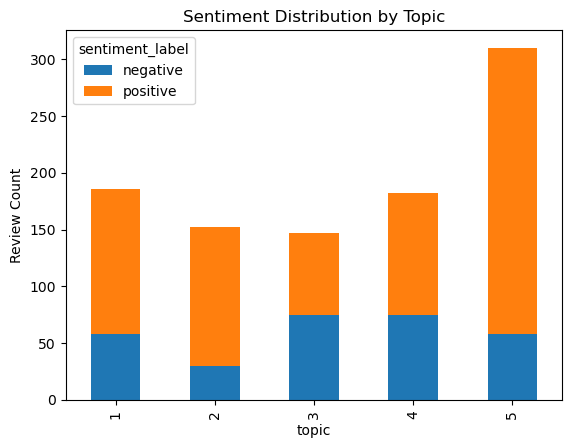

Ratings   1   2   3   4    5
topic                       
1        25  23  22  44   72
2         9  19  12  46   66
3        34  37  17  29   30
4        22  43  41  33   43
5        30  23  28  99  130


<Figure size 1000x500 with 0 Axes>

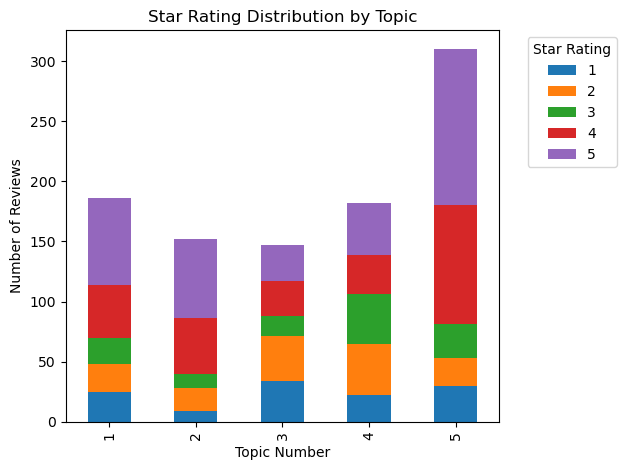

In [ ]:
# Code inspired by:
# "Sentiment Analysis in Python with TextBlob and VADER Sentiment (also Dash p.6) BY SENTDEX"
# YouTube link: https://youtu.be/qTyj2R-wcks?si=qahS9rLWGgWy2eMT
# Accessed on: June 26 2025

# 1. Initialize VADER analyzer
analyser = SentimentIntensityAnalyzer()

# Compute sentiment scores
df['vader_scores'] = df['Feedback'].astype(str).apply(analyser.polarity_scores)
# Extract compound score
df['compound'] = df['vader_scores'].apply(lambda x: x['compound'])
# Map to categorical sentiment
df['sentiment_label'] = df['compound'].apply(lambda c: 'positive' if c >= 0.05 else 'negative')

# 2. Inspect sentiment distribution
print(df['sentiment_label'].value_counts())


# 3. Assign each document to its top topic
df['topic'] = lda_model.transform(dtm).argmax(axis=1) + 1

# 4. Summary table: sentiment by topic
summary = df.groupby(['topic', 'sentiment_label']).size().unstack(fill_value=0)
print(summary)

# 5. Visualize sentiment distribution by topic
summary.plot(kind='bar', stacked=True)
plt.ylabel('Review Count')
plt.title('Sentiment Distribution by Topic')
plt.show()

# 6. Distribution of Star Ratings by Topic
rating_counts = df.groupby(['topic', 'Ratings']).size().unstack(fill_value=0)
print(rating_counts)

# 7. Visualize star rating distribution by topic
plt.figure(figsize=(10,5))
rating_counts.plot(kind='bar', stacked=True)
plt.ylabel('Number of Reviews')
plt.xlabel('Topic Number')
plt.title('Star Rating Distribution by Topic')
plt.legend(title='Star Rating', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


MODEL PERFORMANCE COMPARISON

 VADER SENTIMENT ANALYSIS
----------------------------------------
VADER vs Ground Truth:
              precision    recall  f1-score   support

    Negative       0.71      0.80      0.75       265
    Positive       0.92      0.88      0.90       712

    accuracy                           0.86       977
   macro avg       0.82      0.84      0.83       977
weighted avg       0.86      0.86      0.86       977


 LOGISTIC REGRESSION
----------------------------------------
Logistic Regression on Test Set:
              precision    recall  f1-score   support

    Negative       0.95      0.32      0.48        62
    Positive       0.76      0.99      0.86       134

    accuracy                           0.78       196
   macro avg       0.86      0.66      0.67       196
weighted avg       0.82      0.78      0.74       196


 VADER ON TEST SET (Fair Comparison)
----------------------------------------
VADER on Same Test Set:
              precision    

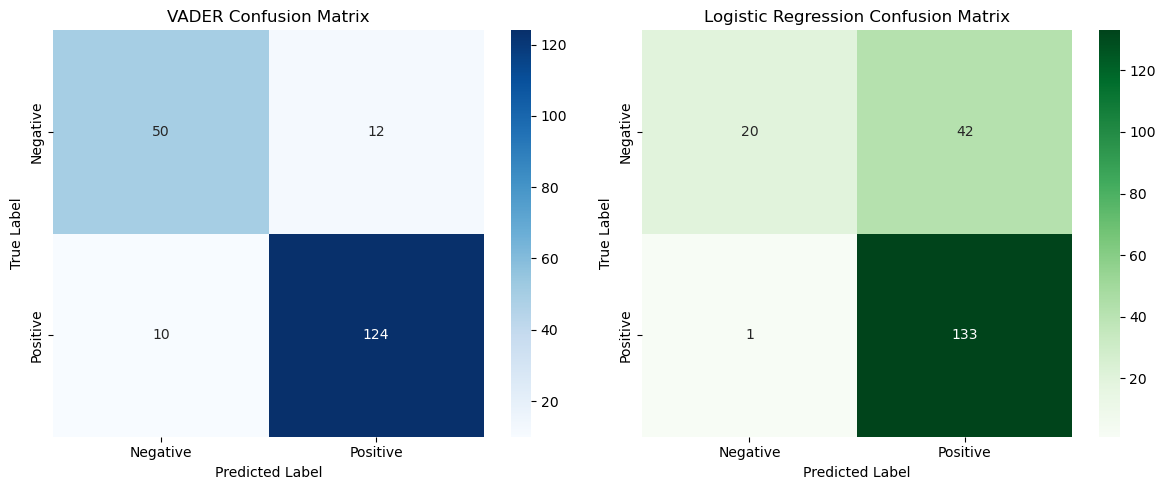

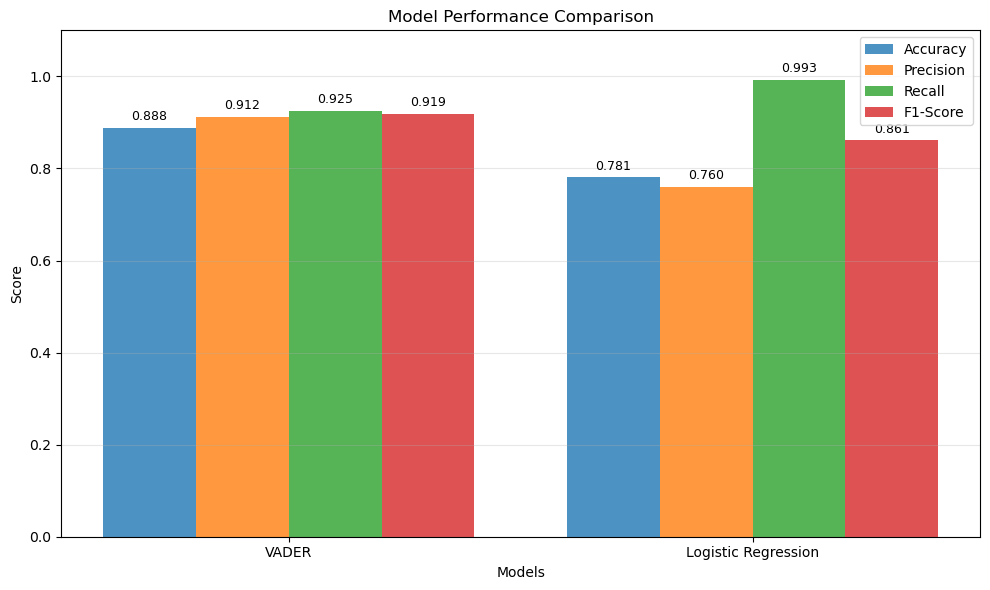

In [ ]:
# Code inspired by:
# "Sentiment Analysis in Python with TextBlob and VADER Sentiment (also Dash p.6) BY SENTDEX"
# YouTube link: https://youtu.be/qTyj2R-wcks?si=qahS9rLWGgWy2eMT
# Accessed on: June 26 2025


# Convert sentiment_label to numerical
df['sentiment_numeric'] = df['sentiment_label'].apply(lambda x: 1 if x == 'positive' else 0)

# Use actual sentiment labels as ground truth
df['vader_numeric'] = df['sentiment_numeric']  # VADER predictions (already numerical)
df['true_numeric'] = df['Sentiment Label']     # Ground truth (replace with your actual column name)

# Prepare data for Logistic Regression
y = df['true_numeric']  # Use ground truth, not VADER predictions
X = dtm

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Logistic Regression
model = LogisticRegression(solver='liblinear', random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# === MODEL EVALUATION ===
print("="*60)
print("MODEL PERFORMANCE COMPARISON")
print("="*60)

# 1. VADER Performance (on full dataset)
print("\n VADER SENTIMENT ANALYSIS")
print("-" * 40)
print("VADER vs Ground Truth:")
print(classification_report(df['true_numeric'], df['vader_numeric'], 
                          target_names=['Negative', 'Positive']))

# 2. Logistic Regression Performance (on test set)
print("\n LOGISTIC REGRESSION")
print("-" * 40)
print("Logistic Regression on Test Set:")
print(classification_report(y_test, y_pred, 
                          target_names=['Negative', 'Positive']))

# 3. VADER Performance on Test Set (for fair comparison)
test_indices = X_test.index if hasattr(X_test, 'index') else y_test.index
vader_test_pred = df.loc[test_indices, 'vader_numeric']

print("\n VADER ON TEST SET (Fair Comparison)")
print("-" * 40)
print("VADER on Same Test Set:")
print(classification_report(y_test, vader_test_pred, 
                          target_names=['Negative', 'Positive']))

# 4. Performance Summary
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print("\n PERFORMANCE SUMMARY")
print("-" * 40)
print(f"{'Metric':<15} {'VADER':<10} {'LogReg':<10} {'Winner':<10}")
print("-" * 45)

# Calculate metrics
vader_acc = accuracy_score(y_test, vader_test_pred)
vader_f1 = f1_score(y_test, vader_test_pred)
vader_precision = precision_score(y_test, vader_test_pred)
vader_recall = recall_score(y_test, vader_test_pred)

lr_acc = accuracy_score(y_test, y_pred)
lr_f1 = f1_score(y_test, y_pred)
lr_precision = precision_score(y_test, y_pred)
lr_recall = recall_score(y_test, y_pred)

# Print comparison
metrics = [
    ('Accuracy', vader_acc, lr_acc),
    ('Precision', vader_precision, lr_precision),
    ('Recall', vader_recall, lr_recall),
    ('F1-Score', vader_f1, lr_f1)
]

for metric_name, vader_score, lr_score in metrics:
    winner = "VADER" if vader_score > lr_score else "LogReg" if lr_score > vader_score else "Tie"
    print(f"{metric_name:<15} {vader_score:<10.3f} {lr_score:<10.3f} {winner:<10}")

# 5. Confusion Matrices
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# VADER Confusion Matrix
cm_vader = confusion_matrix(y_test, vader_test_pred)
sns.heatmap(cm_vader, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Negative', 'Positive'], 
            yticklabels=['Negative', 'Positive'], ax=axes[0])
axes[0].set_title('VADER Confusion Matrix')
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')

# Logistic Regression Confusion Matrix
cm_lr = confusion_matrix(y_test, y_pred)
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Negative', 'Positive'], 
            yticklabels=['Negative', 'Positive'], ax=axes[1])
axes[1].set_title('Logistic Regression Confusion Matrix')
axes[1].set_ylabel('True Label')
axes[1].set_xlabel('Predicted Label')

plt.tight_layout()
plt.show()

# 6. Performance Visualization
fig, ax = plt.subplots(figsize=(10, 6))

models = ['VADER', 'Logistic Regression']
x_pos = range(len(models))
width = 0.2

metrics_data = {
    'Accuracy': [vader_acc, lr_acc],
    'Precision': [vader_precision, lr_precision],
    'Recall': [vader_recall, lr_recall],
    'F1-Score': [vader_f1, lr_f1]
}

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

for i, (metric, values) in enumerate(metrics_data.items()):
    positions = [p + i * width for p in x_pos]
    bars = ax.bar(positions, values, width, label=metric, alpha=0.8, color=colors[i])
    
    # Add value labels on bars
    for bar, value in zip(bars, values):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                f'{value:.3f}', ha='center', va='bottom', fontsize=9)

ax.set_xlabel('Models')
ax.set_ylabel('Score')
ax.set_title('Model Performance Comparison')
ax.set_xticks([p + width * 1.5 for p in x_pos])
ax.set_xticklabels(models)
ax.legend()
ax.set_ylim(0, 1.1)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Interpretation

VADER sentiment analysis demonstrates superior overall performance compared to the Logistic Regression model. While both models show strengths in different areas, VADER achieves higher accuracy (88.8% vs 78.1%), precision (91.2% vs 76.0%), and F1-score (91.9% vs 86.1%). The key differentiator is VADER's balanced performance across metrics versus Logistic Regression's significant recall-precision tradeoff.

Notably, Logistic Regression shows exceptional recall (99.3%), indicating it captures nearly all positive sentiments but at the cost of lower precision (76.0%). This suggests the supervised model may be overfitting to positive cases, while VADER's rule-based approach maintains better generalization across both positive and negative classes, as evidenced by its higher F1-score for negative sentiment (75% vs 48%).

For hospital feedback analysis where both false positives and false negatives carry business consequences, VADER provides more reliable overall results. Its strength with informal language patterns in reviews makes it particularly suitable for this healthcare feedback dataset.

# Word Cloud based on sentement( Positive & Negative )

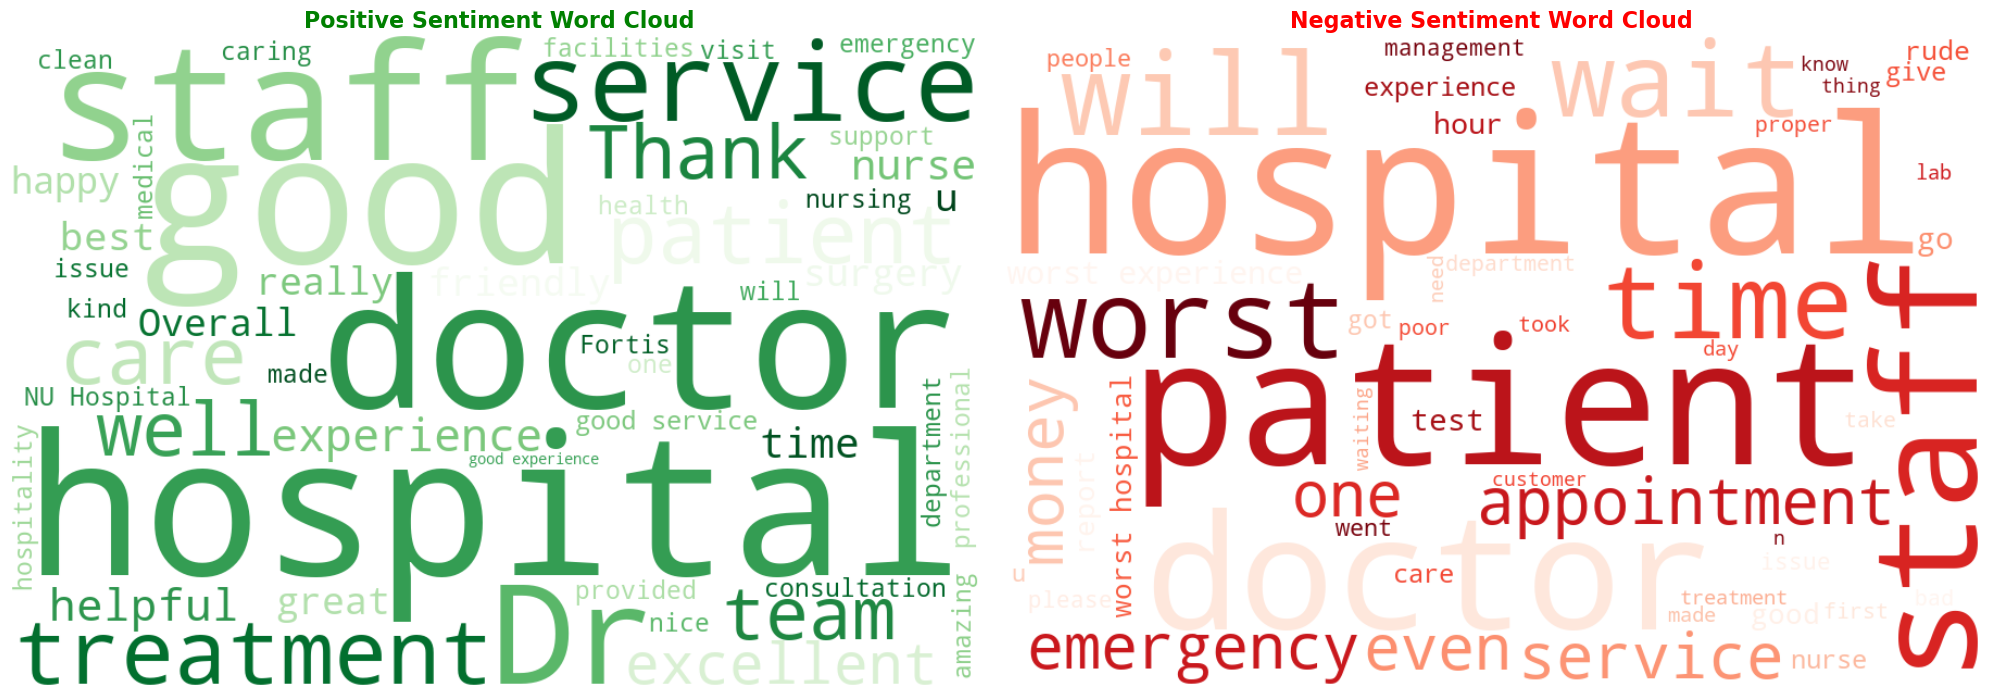

In [45]:
# Code inspired by:
# "Find the Most COMMON Words with Python WordCloud" by Data with Dylan
# YouTube link: https://www.youtube.com/watch?v=jB1XMrv_dCA
# Accessed on: June 24 2025

def create_sentiment_wordclouds(df, text_column, sentiment_column):
    
    # Separate positive and negative reviews
    positive_text = ' '.join(df[df[sentiment_column] == 1][text_column].astype(str))
    negative_text = ' '.join(df[df[sentiment_column] == 0][text_column].astype(str))
    
    # Create subplots
    fig, axes = plt.subplots(1, 2, figsize=(20, 8))
    
    # Positive sentiment word cloud
    if positive_text.strip():  # Check if there's positive text
        wordcloud_pos = WordCloud(width=900, height=600,
                                 background_color='white',
                                 max_words=50,
                                 colormap='Greens').generate(positive_text)
        axes[0].imshow(wordcloud_pos, interpolation='bilinear')
        axes[0].set_title('Positive Sentiment Word Cloud', fontsize=16, fontweight='bold', color='green')
        axes[0].axis('off')
    
    # Negative sentiment word cloud
    if negative_text.strip(): 
        wordcloud_neg = WordCloud(width=900, height=600,
                                 background_color='white',
                                 max_words=50,
                                 colormap='Reds').generate(negative_text)
        axes[1].imshow(wordcloud_neg, interpolation='bilinear')
        axes[1].set_title('Negative Sentiment Word Cloud', fontsize=16, fontweight='bold', color='red')
        axes[1].axis('off')
    
    plt.tight_layout()
    plt.show()

create_sentiment_wordclouds(df, 'Feedback', 'Sentiment Label') 

# Interpretation

We can see the key words most patiens complain are about staff, waiting time, and apointments. With the major word hospital being an icon, possibly due to it being used to identify the hosipital.

If a comapny were to focus on addressing issues like long wating times, rude staff and below par appointments the hospital would see a drastic reduction in negatvie reviews

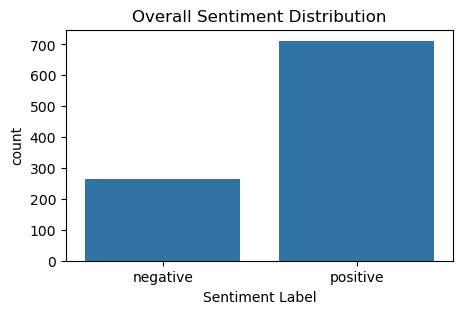

In [46]:
# Overall Sentiment Distribution
plt.figure(figsize=(5,3))
sns.countplot(x='Sentiment Label', data=df)
plt.xticks([0,1], ['negative','positive'])
plt.title("Overall Sentiment Distribution")
plt.show()